In [1]:
!pip install plotly

In [2]:
#Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from skimage.filters import sobel
import plotly.express as px
from scipy.signal import convolve2d

In [3]:
# Load the handwritten digits dataset
digits = load_digits()
#Chaque ligne représente une image à plat (flattened en 1D), donc une observation.
print("Dimensions des données :")
print("- digits.data.shape :", digits.data.shape)
print("- digits.images.shape :", digits.images.shape)
print("Nombre de classes :", len(np.unique(digits.target)))

Dimensions des données :
- digits.data.shape : (1797, 64)
- digits.images.shape : (1797, 8, 8)
Nombre de classes : 10


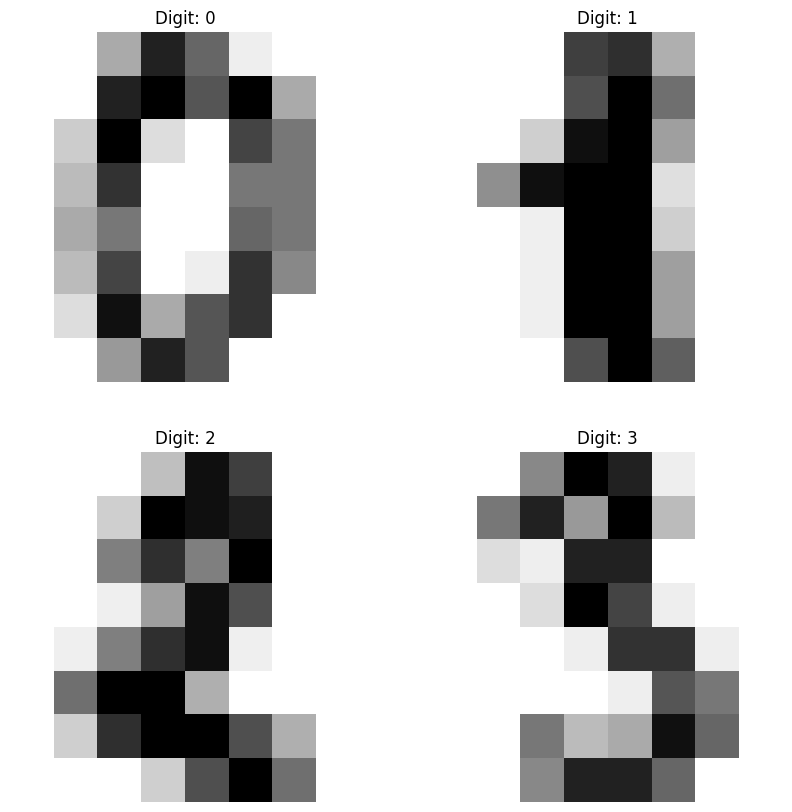

In [4]:
# Visualize some images
# Graph the first4 images from the data base
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(digits.images[i], cmap='binary')
    plt.title(f"Digit: {digits.target[i]}")
    plt.axis('off')
plt.show()

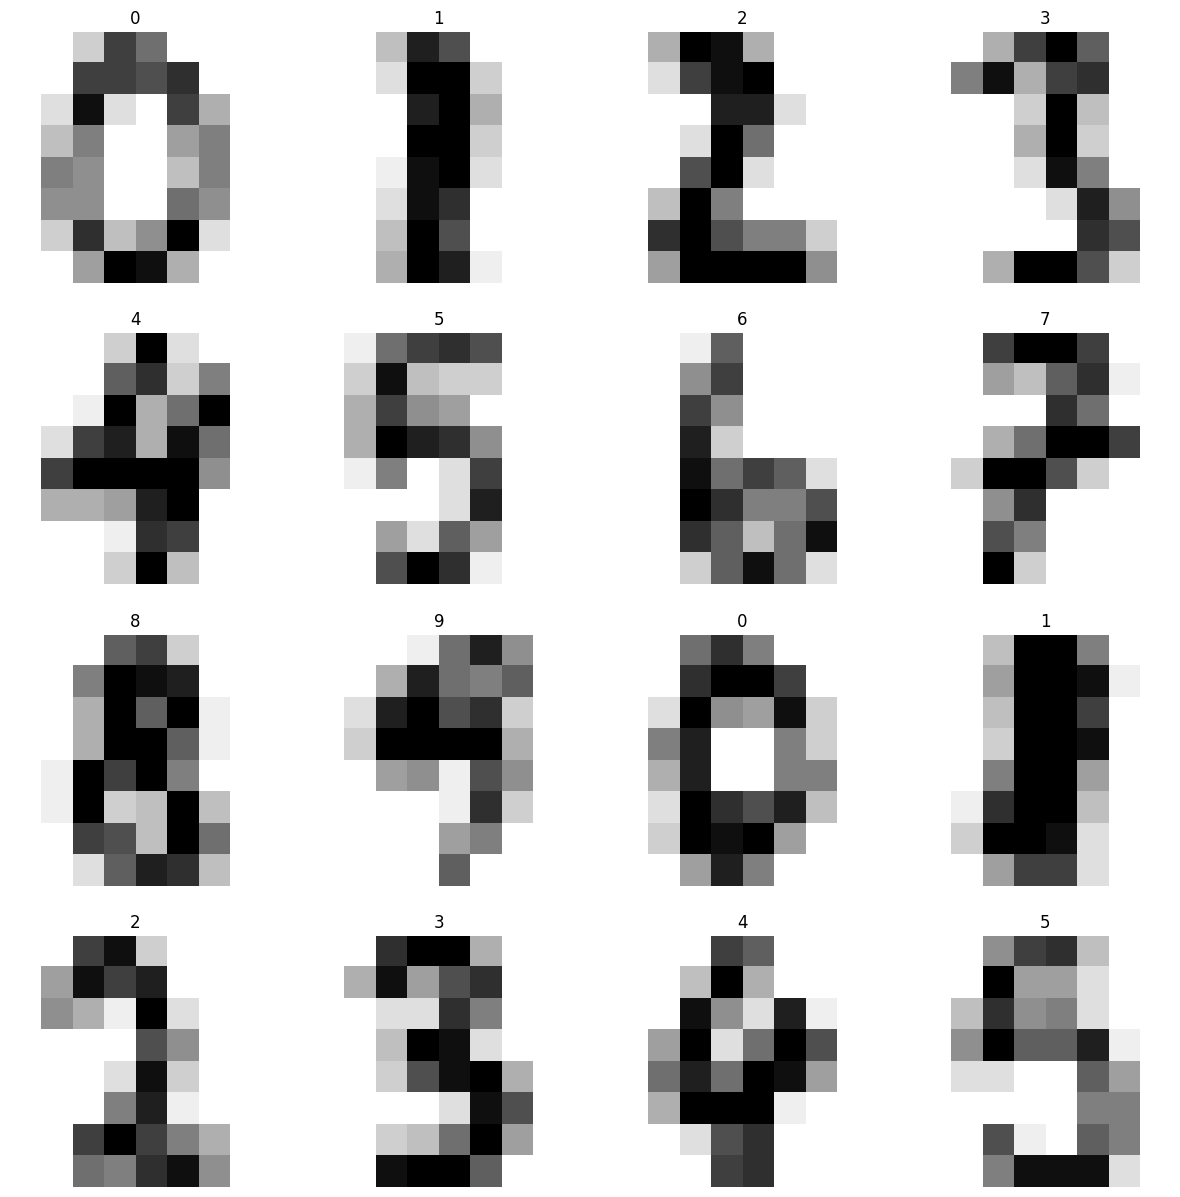

In [5]:
# Display at least one random sample par class (some repetitions of class... oh well)
def plot_multi(data, y):
    '''Plots 16 digits'''
    nplots = 16
    nb_classes = len(np.unique(y))
    cur_class = 0
    fig = plt.figure(figsize=(15,15))
    for j in range(nplots):
        plt.subplot(4,4,j+1)
        to_display_idx = np.random.choice(np.where(y == cur_class)[0])
        plt.imshow(data[to_display_idx].reshape((8,8)), cmap='binary')
        plt.title(cur_class)
        plt.axis('off')
        cur_class = (cur_class + 1) % nb_classes
    plt.show()

plot_multi(digits.data, digits.target)

Statistiques sur les classes :
Class 0: 178 samples
Class 1: 182 samples
Class 2: 177 samples
Class 3: 183 samples
Class 4: 181 samples
Class 5: 182 samples
Class 6: 181 samples
Class 7: 179 samples
Class 8: 174 samples
Class 9: 180 samples


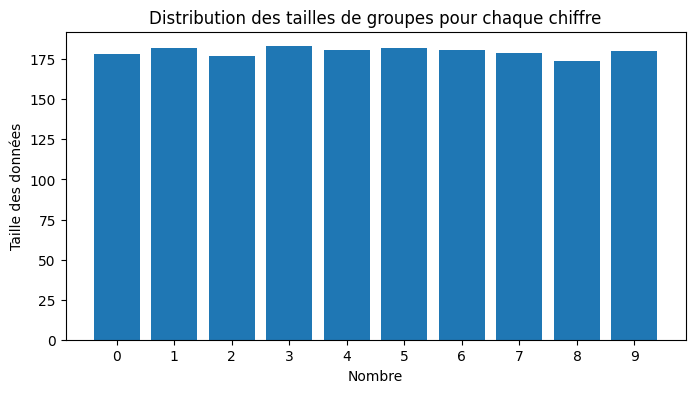

In [6]:
##########################################
## Data exploration and first analysis
##########################################

def get_statistics_text(targets):
  labels, counts=np.unique(targets, return_counts=True)
  stats={"Label names": list(labels),"Number of elements per class": dict(zip(labels, counts))}
  for u, c in zip(labels, counts):
    print(f"Class {u}: {c} samples")
  return stats

print("Statistiques sur les classes :")
stats=get_statistics_text(digits.target)




plt.figure(figsize=(8, 4))
plt.bar(stats["Number of elements per class"].keys(), stats["Number of elements per class"].values())
plt.xlabel("Nombre")
plt.ylabel("Taille des données")
plt.title("Distribution des tailles de groupes pour chaque chiffre")
plt.xticks(list(stats["Number of elements per class"].keys()))
plt.show()

In [7]:

##########################################
## Start data preprocessing
##########################################

# Access the whole dataset as a matrix where each row is an individual (an image in our case)
# and each column is a feature (a pixel intensity in our case)
## X = [
#  [Pixel1, Pixel2, ..., Pixel64],  # Image 1 as a row
#  [Pixel1, Pixel2, ..., Pixel64],  # Image 2 as a row
#  [Pixel1, Pixel2, ..., Pixel64],  # Image 3 as a row
#  [Pixel1, Pixel2, ..., Pixel64]   # Image 4 as a row
#]

digits.data.shape
X=digits.data
y=digits.target

# Print dataset shape
print(f"Feature matrix shape: {X.shape}. Max value = {np.max(X)}, Min value = {np.min(X)}, Mean value = {np.mean(X)}")
print(f"Labels shape: {y.shape}")



Feature matrix shape: (1797, 64). Max value = 16.0, Min value = 0.0, Mean value = 4.884164579855314
Labels shape: (1797,)


In [8]:


# Normalisation des données
F=MinMaxScaler().fit_transform(X)

# Print matrix shape
print(f"Feature matrix F shape: {F.shape}. Max value = {np.max(F)}, Min value = {np.min(F)}, Mean value = {np.mean(F)}")

Feature matrix F shape: (1797, 64). Max value = 1.0, Min value = 0.0, Mean value = 0.3071437902148591


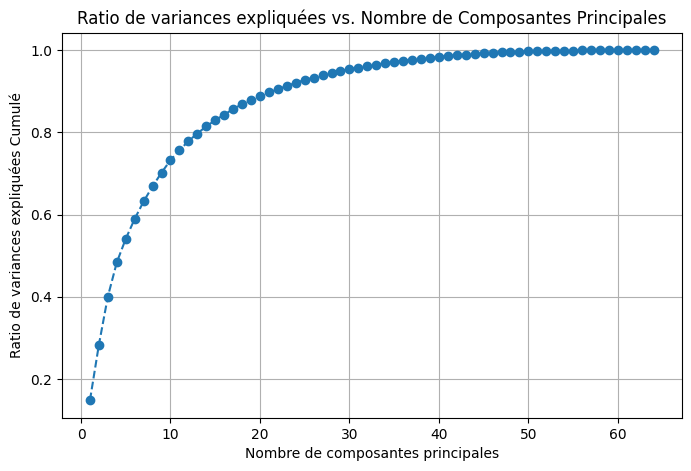

In [9]:
##########################################
## Dimensionality reduction
##########################################


### just an example to test, for various number of PCs
sample_index = 0
original_image = F[sample_index].reshape(8, 8)  # Reshape back to 8×8 for visualization

#n_components == min(digits.data.shape[0], digits.data.shape[1])
#print(n_components)




# Expolore the explanined variance of PCA and plot
pca_64=PCA(n_components=64)
F_pca_64=pca_64.fit(F)

explained_variance_ratio=pca_64.explained_variance_ratio_
cumulative_explained_variance=np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 65), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Ratio de variances expliquées Cumulé")
plt.title("Ratio de variances expliquées vs. Nombre de Composantes Principales")
plt.grid(True)
plt.show()



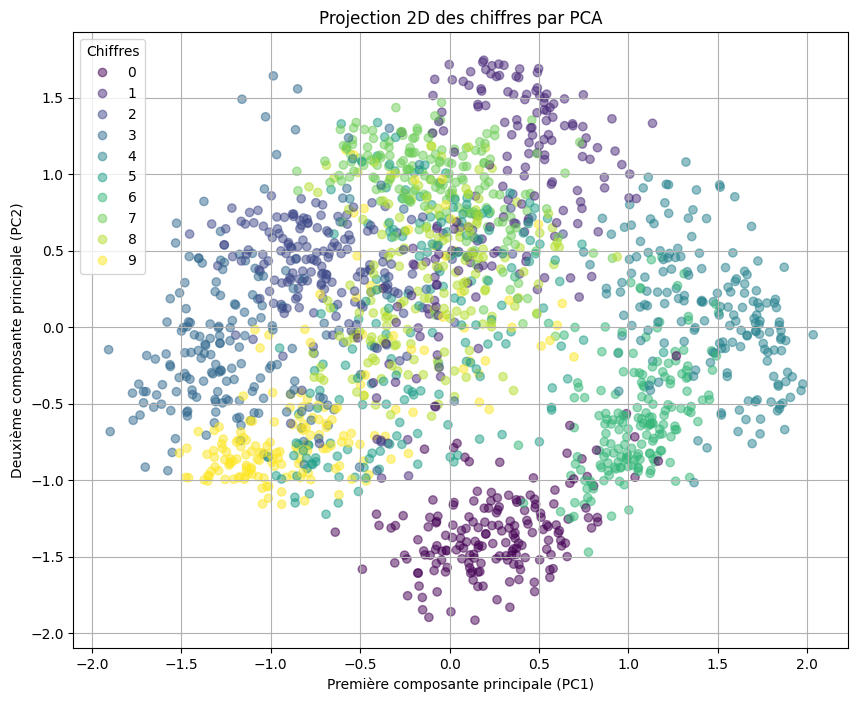

In [10]:
# Display the whole database in 2D
pca_2=PCA(n_components=2)
F_pca_2=pca_2.fit_transform(F)

plt.figure(figsize=(10, 8))
scatter=plt.scatter(F_pca_2[:, 0], F_pca_2[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel("Première composante principale (PC1)")
plt.ylabel("Deuxième composante principale (PC2)")
plt.title("Projection 2D des chiffres par PCA")
legend=plt.legend(*scatter.legend_elements(), title="Chiffres")
plt.grid(True)
plt.show()

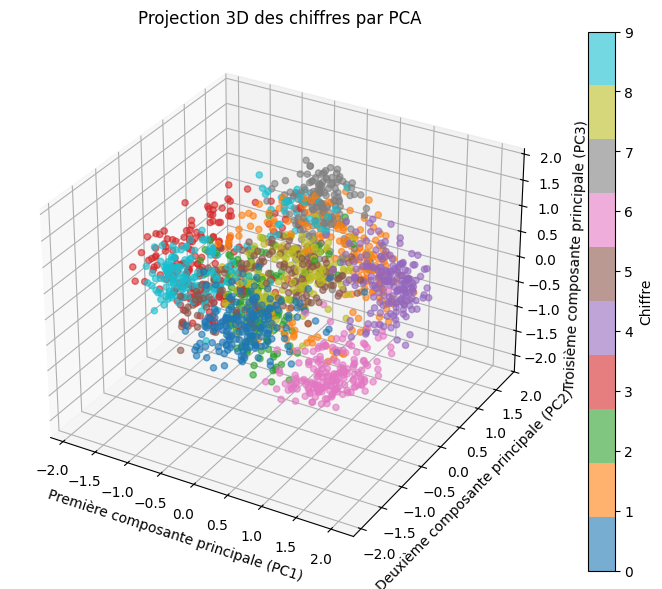

In [12]:
# PCA à 3 composantes principales
pca_3=PCA(n_components=3)
X_pca_3=pca_3.fit_transform(F)
#print(pca3.explained_variance_ratio_)
# Affichage 3D avec coloration par classe
fig=plt.figure(figsize=(10, 7))
ax=fig.add_subplot(111, projection='3d')
scatter=ax.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], c=digits.target, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Chiffre')
ax.set_xlabel("Première composante principale (PC1)")
ax.set_ylabel("Deuxième composante principale (PC2)")
ax.set_zlabel("Troisième composante principale (PC3)")
plt.title("Projection 3D des chiffres par PCA")
plt.show()

In [13]:
# PCA à 3 composantes principales (graphique intéractif)
pca_3=PCA(n_components=3)
X_pca_3=pca_3.fit_transform(F)
#print(pca3.explained_variance_ratio_)
# Affichage 3D avec coloration par classe
fig=px.scatter_3d(x=X_pca_3[:, 0],y=X_pca_3[:, 1],z=X_pca_3[:, 2],color=y.astype(str),labels={'x': 'Première composante principale (PC1)','y': 'Deuxième composante principale (PC2)','z': 'Troisième composante principale (PC3)','color': 'Chiffres'},
    title="Projection 3D interactive des Chiffres par PCA", size=[0.4] * len(X_pca_3))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()

Matrice de F_pca pour 20 n components: (1797, 20)
Ratio de variance expliquée pour la PCA à 1 composantes: [0.14815157]

Ratio de variance expliquée pour la PCA à 2 composantes: [0.14815157 0.13523675]

Ratio de variance expliquée pour la PCA à 3 composantes: [0.14815157 0.13523675 0.11706654]

Ratio de variance expliquée pour la PCA à 4 composantes: [0.14815157 0.13523675 0.11706654 0.08316524]

Ratio de variance expliquée pour la PCA à 5 composantes: [0.14815157 0.13523675 0.11706654 0.08316524 0.05736613]

Ratio de variance expliquée pour la PCA à 6 composantes: [0.14815157 0.13523675 0.11706654 0.08316524 0.05736613 0.0485009 ]

Ratio de variance expliquée pour la PCA à 8 composantes: [0.14815157 0.13523675 0.11706654 0.08316524 0.05736613 0.0485009
 0.04252881 0.03677515]

Ratio de variance expliquée pour la PCA à 9 composantes: [0.14815157 0.13523675 0.11706654 0.08316524 0.05736613 0.0485009
 0.04252881 0.03677515 0.03323376]

Ratio de variance expliquée pour la PCA à 10 composa

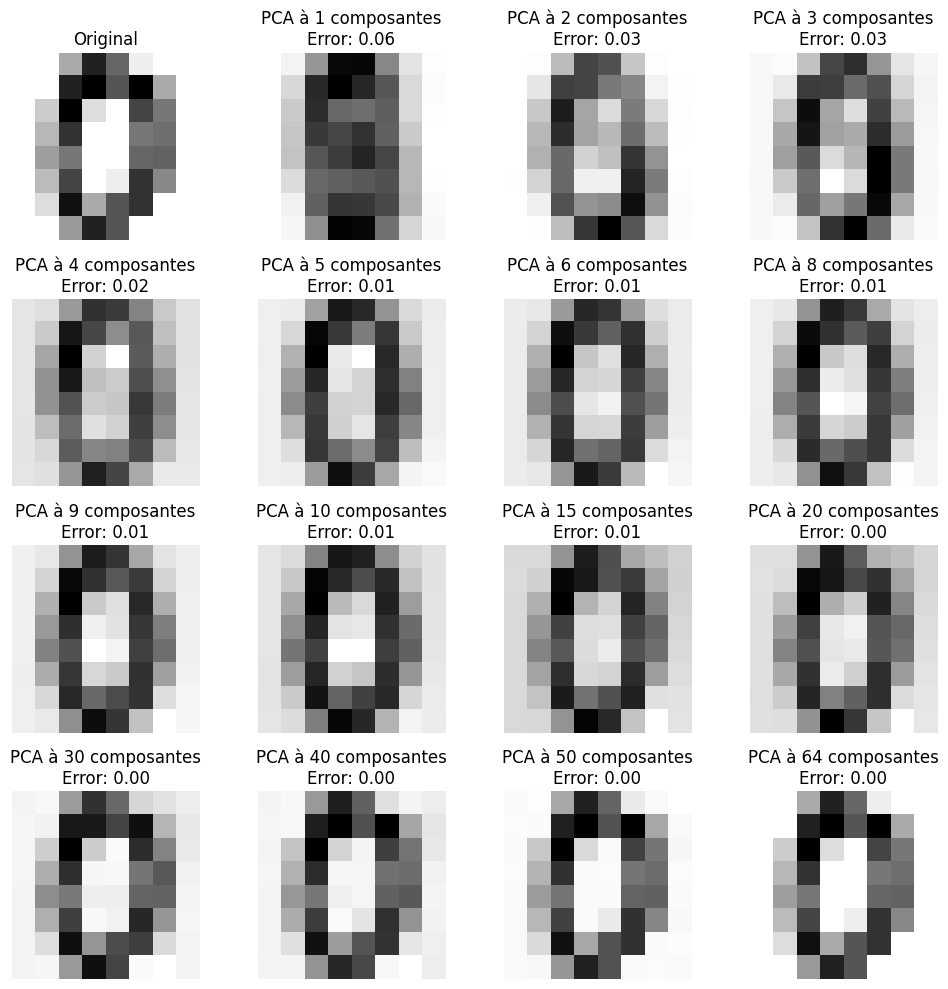

In [14]:
### Create a 20 dimensional PCA-based feature matrix

pca_20=PCA(n_components=20)
F_pca_20=pca_20.fit_transform(F)

# Print reduced feature matrix shape
print(f"Matrice de F_pca pour 20 n components: {F_pca_20.shape}")


n_components_list=[1, 1, 2, 3, 4, 5, 6, 8, 9, 10, 15, 20, 30, 40, 50, 64]

fig,axes=plt.subplots(4, 4, figsize=(10, 10))
axes=axes.ravel()

axes[0].imshow(original_image, cmap='binary')
axes[0].set_title("Original")
axes[0].axis('off')

for i, n_components_i in enumerate(n_components_list[1:]):
    pca_i=PCA(n_components=n_components_i)
    pca_i.fit(F)
    sample_pca=pca_i.transform(F[sample_index].reshape(1, -1)) #sample index vaut 0
    i_reconstructed=pca_i.inverse_transform(sample_pca)
    reconstructed_image=i_reconstructed.reshape(8, 8)
    mse=mean_squared_error(original_image.flatten(), reconstructed_image.flatten())
    evr=pca_i.explained_variance_ratio_
    print(f"Ratio de variance expliquée pour la PCA à {n_components_i} composantes: {evr}\n")
    axes[i+1].imshow(reconstructed_image, cmap='binary')
    axes[i+1].set_title(f"PCA à {n_components_i} composantes\nError: {mse:.2f}")
    axes[i+1].axis('off')


plt.tight_layout()
plt.show()




In [15]:
##########################################
## Feature engineering
##########################################
### # Function to extract zone-based features
###  Zone-Based Partitioning is a feature extraction method
### that helps break down an image into smaller meaningful regions to analyze specific patterns.
def extract_zone_features(images):
  n_data,n_target=images.shape
  zones=[]
  for img in images :
    img8=img.reshape(8,8)
    zone1_mean=np.mean(img8[:3,:])
    zone2_mean=np.mean(img8[3:5,:])
    zone3_mean=np.mean(img8[5:,:])
    zones.append([zone1_mean,zone2_mean,zone3_mean])
  return np.array(zones)


# Apply zone-based feature extraction
F_zones=extract_zone_features(F)

# Print extracted feature shape
print(f"Feature matrix F_zones shape: {F_zones.shape}")


Feature matrix F_zones shape: (1797, 3)


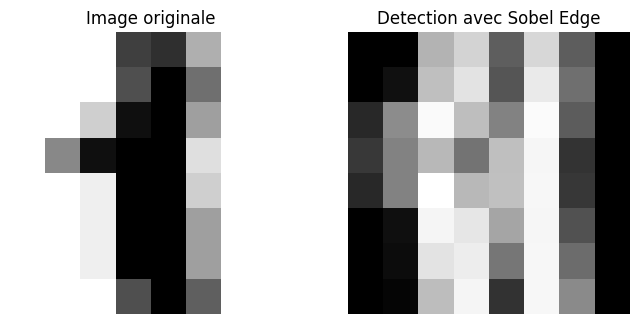

In [16]:
### Edge detection features

# Get used to the Sobel filter by applying it to an image and displaying both the original image
# and the result of applying the Sobel filter side by side
sample_img_8x8=F[1].reshape(8, 8) #à voir pour différentes valeurs
edge_img=sobel(sample_img_8x8)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_img_8x8, cmap='binary')
plt.title("Image originale")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edge_img, cmap='gray')
plt.title("Detection avec Sobel Edge")
plt.axis('off')
plt.show()

In [17]:
# Compute the average edge intensity for each image and return it as an n by 1 array
def compute_average_edge_intensity(images):
    average_edge_intensities=[]
    for img in images:
        img8=img.reshape(8, 8)
        edges=sobel(img8)
        average_intensity=np.mean(edges)
        average_edge_intensities.append(average_intensity)
    return np.array(average_edge_intensities).reshape(-1, 1)

F_edges=compute_average_edge_intensity(F)

# Print feature shape after edge extraction
print(f"Feature matrix F_edges shape: {F_edges.shape}")

### connect all the features together

# Concatenate PCA, zone-based, and edge features
F_final=np.concatenate((F_pca_20, F_zones, F_edges), axis=1)

# Normalize final features
F_final=MinMaxScaler().fit_transform(F_final)

# Print final feature matrix shape
print(f"Final feature matrix F_final shape: {F_final.shape}")

Feature matrix F_edges shape: (1797, 1)
Final feature matrix F_final shape: (1797, 24)


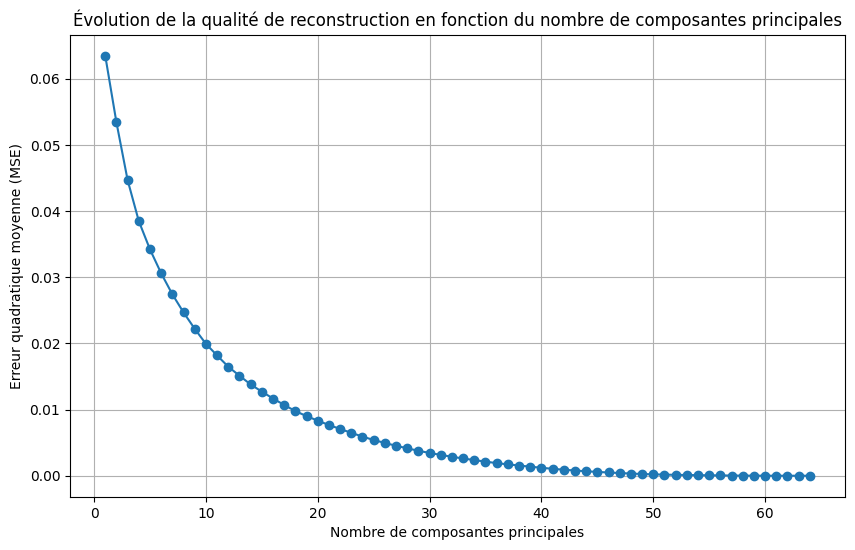

In [18]:
def evolution_quality(F):
    """Affiche l'évolution de la qualité de reconstruction en fonction du nombre de composantes principales."""
    n_components=np.arange(1, F.shape[1] + 1)  # De 1 à 64 pour ce dataset
    mse_values=[]

    for n in n_components:
        pca_temp=PCA(n_components=n)
        X_pca_temp=pca_temp.fit_transform(F)
        X_reconstructed_temp=pca_temp.inverse_transform(X_pca_temp)
        mse=mean_squared_error(F, X_reconstructed_temp)
        mse_values.append(mse)

    plt.figure(figsize=(10, 6))
    plt.plot(n_components, mse_values, marker='o')
    plt.title("Évolution de la qualité de reconstruction en fonction du nombre de composantes principales")
    plt.xlabel("Nombre de composantes principales")
    plt.ylabel("Erreur quadratique moyenne (MSE)")
    plt.grid()
    plt.show()

evolution_quality(F)